# State Assignment Using Decision Trees
Explore doing state assignment with decision trees. 

- Handle small classes by combining classes.
- Do crossvalidation
- Explore sensitivity to perturbations in the data

In [1]:
import init
from common import constants as cn
from common.data_provider import DataProvider
from common import transform_data
from common_python.statistics import empirical_distribution_generator, density, multiple_density, util_statistics
from common_python.plots import util_plots
from plots import util_plots as uplots


from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import collections
import seaborn as sns

%matplotlib inline

## Generate Classification Data

1. T0 is eliminated
1. Normoxia is combined with Resuscitation (because of small number of Normoxia)
1. Perfectly correlated genes are combined

In [2]:
provider = DataProvider()
provider.do()
len(provider.df_normalized)

2582

In [3]:
# Geenrate the feature data
def makeFeatureDF(provider):
    df_Xdata = transform_data.aggregateGenes(provider=provider)
    df_Xdata = df_Xdata.T
    df_Xdata = df_Xdata.drop(index="T0")
    data_features = df_Xdata.columns
    df_Xdata.columns = range(len(data_features))
    return df_Xdata

def makeFeatureColumns(provider):
    df_X = transform_data.aggregateGenes(provider=provider)
    df_X = df_X.T
    return df_X.columns.tolist()


df_Xdata = makeFeatureDF(provider)
df_Xdata.head()

,0,1,2,3,4,5,6,7,8,9,...,1505,1506,1507,1508,1509,1510,1511,1512,1513,1514
T1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T5,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1


There are only two Noroxia states, one of which is a reference state. So, for the class data, we combine
Noroxia with Resusitation.

In [4]:
# Prepare the state data
def makeClassSer(provider):
    ser_state = provider.df_stage_matrix[cn.STAGE_NAME]
    ser_state = ser_state.drop(index="T0")
    ser_state = ser_state.copy()
    ser_state[ser_state == 'Normoxia'] = 'Resuscitation'
    # Create converter from state name to numeric index
    states = ser_state.unique()
    state_dict = {k: v for v, k in enumerate(states)}
    ser = ser_state.apply(lambda k: state_dict[k] )
    return ser
ser_Ydata = makeClassSer(provider)

## Common Codes

In [ ]:
# View the tree
def viewTree(df_X, ser_Y):
    dtree = tree.DecisionTreeClassifier(criterion = "entropy")
    dtree = dtree.fit(df_X, ser_Y)
    with open("dtree.dot", 'w') as fd:
        dotfile = tree.export_graphviz(dtree, out_file = fd, feature_names = df_X.columns)
    !dot -Tpng dtree.dot -o dtree.png

## sklearn Decision Trees

In [ ]:
clf = DecisionTreeClassifier(random_state=0)
iris = load_iris()
cross_val_score(clf, iris.data, iris.target, cv=10)

array([1.        , 0.93333333, 1.        , 0.93333333, 0.93333333,
       0.86666667, 0.93333333, 1.        , 1.        , 1.        ])

In [ ]:
type(iris.data)

numpy.ndarray

In [ ]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
# A different approach. Using dot directly.
from pandas import read_csv, DataFrame
from sklearn import tree
from os import system

Y = iris.target
X = pd.DataFrame(iris.data)

dtree = tree.DecisionTreeClassifier(criterion = "entropy")
dtree = dtree.fit(X, Y)

with open("dtree.dot", 'w') as fd:
    dotfile = tree.export_graphviz(dtree, out_file = fd, feature_names = X.columns)
!dot -Tpng dtree.dot -o dtree.png
#system("firefox file:///%s/dtree.png" % os.getcwd() )

<img src="dtree.png"> 

## Covariance Structure of Features

In [ ]:
df_data = makeFeatureDF(provider)
df_data.head()

,0,1,2,3,4,5,6,7,8,9,...,1505,1506,1507,1508,1509,1510,1511,1512,1513,1514
T1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T5,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1


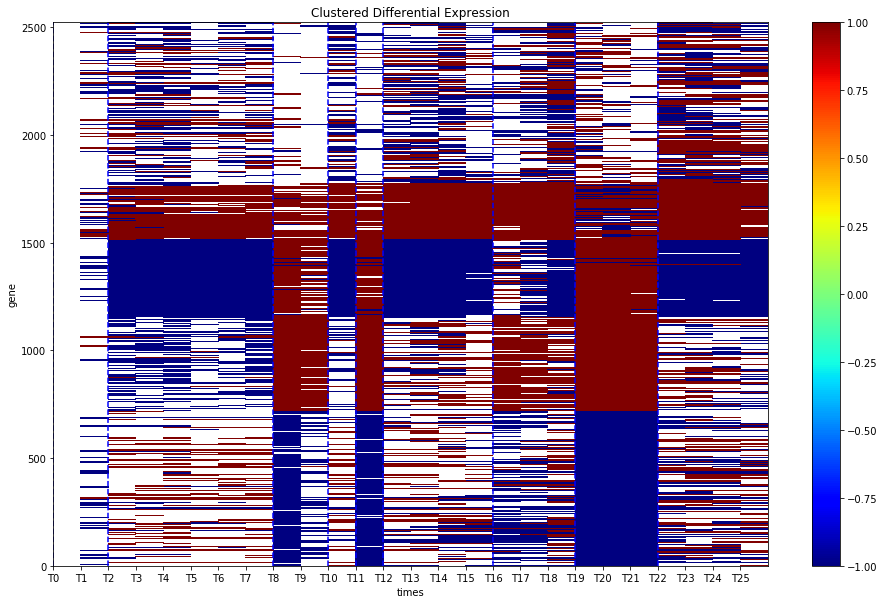

In [ ]:
uplots.plotClusteredHeatmap(provider=provider)

In [ ]:
df_corr = df_data.corr()
df_corr = df_corr.applymap(lambda v: 0 if np.isnan(v) else v)
cg = sns.clustermap(df_corr, cbar_kws={"ticks":[-1,1]}, cmap="jet")

## Decision Tree for Expression Data

In [ ]:
clf = DecisionTreeClassifier(random_state=0)
results = cross_val_score(clf, makeFeatureDF(provider), makeClassSer(provider), cv=3)
print("Mean: %f\nStd: %f" % (np.mean(results), np.std(results)))

In [ ]:
viewTree(df_Xdata, ser_Ydata)

The gene groups used in the resulting tree are listed below.

In [ ]:
gene_groups = [109,616, 218, 1087]
features = makeFeatureColumns(provider)
for group in gene_groups:
    print(features[group])

In [ ]:
len(makeFeatureColumns(provider))

In [ ]:
gene_groups = [109,616, 218, 1087]
features = makeFeatureColumns(provider)
df_plot =  transform_data.aggregateGenes(provider=provider)
df_plot = df_plot.drop(columns=["T0"])
column_names = [features[g] for g in gene_groups]
df_plot = df_plot.T
df_plot = df_plot[column_names]
df_plot = df_plot.copy()
df_plot = df_plot.T
df_plot.columns = [c.replace("T","") for c in df_plot.columns]
df_plot.columns = ["" if int(c) % 2 == 0 else c for c in df_plot.columns]
df_plot.head()

In [ ]:
df_dtgenes = pd.DataFrame({'num': gene_groups, 'name': column_names})

In [ ]:

#df_plot = df_plot.applymap(lambda v: np.nan if np.isclose(v, 0) else v)
ax = uplots.plotStateTransitions(is_plot=False, ex_timepoints=["T0"], color="black")
ax.set_ylim((0,4))
_ = util_plots.plotCategoricalHeatmap(df_plot, ax = ax, ymax=len(df_plot), xoffset=0)



In [ ]:
df_plot.head()

**Notes**
1. Expect few changes in gene expression between adjacent states

# Analyze Decorrelated Expression Data

In [ ]:
df_decor = util_statistics.decorrelate(df_Xdata.T)
df_Xdata_decor = df_decor.T
clf = DecisionTreeClassifier(random_state=0)
cross_val_score(clf, df_Xdata_decor, ser_Ydata, cv=3)

In [ ]:
viewTree(df_Xdata_decor, ser_Ydata)

In [ ]:
xvs = []
for _ in range(1000):
    df_decor = util_statistics.decorrelate(df_Xdata_decor.T)
    df_Xdata_decor = df_decor.T
    clf = DecisionTreeClassifier(random_state=0)
    xvs.append(np.mean(cross_val_score(clf, df_Xdata_decor, ser_Ydata, cv=3)))

In [ ]:
xvs[0:10]

In [ ]:
xvs.sort()
yvs = [(1.0*v) / len(xvs) for v in range(len(xvs))]
plt.plot(xvs, yvs, [0.8, 0.8], [0, 1], 'r', linestyle='dashed')
plt.plot([0.21, 0.21], [0, 1], 'g', linestyle='dashed')
plt.xlim(0, 1.0)
plt.xlabel("Accuracy")
plt.ylabel("Probability")
plt.text(0.7, 0.6, "DT-All")
plt.text(0.35, 0.8, "Random Classifier")
plt.text(0.16, 0.6, "q")

**Notes**
1. Calculate a distribution of average accuracy for decorrelated data. Plot CDF and show where data lies with std.
1. This looks like a logistic distribution centered at the expected accuracy for a random classifier (selects class from the distribution of observed classes).

# Effect of Fractional Decorrelations

Bug is that I'm sampling X but not keeping the associated Y.

In [ ]:
def calcClassificationAccuracy(provider, frac):
    """
    :param float frac: fraction decorrelate
    :return float, float: mean, std of classification error
    """
    NUM_REPETITIONS = 20
    df_X = makeFeatureDF(provider)
    ser_Y = makeClassSer(provider)
    generator = empirical_distribution_generator.EmpiricalDistributionGenerator(df_X)
    df = generator.synthesize(-1, frac)
    means = []
    stds = []
    for _ in range(NUM_REPETITIONS):
        generator = empirical_distribution_generator.EmpiricalDistributionGenerator(df)
        df = generator.synthesize(-1, frac)
        clf = DecisionTreeClassifier(random_state=0)
        accuracies = cross_val_score(clf, df, ser_Y, cv=3)
        means.append(np.mean(accuracies))
        stds.append(np.std(accuracies) / np.sqrt(len(accuracies)))
    return np.mean(means), np.mean(stds)

In [ ]:
calcClassificationAccuracy(provider, 0.02)

In [ ]:
fracs = [0.01*v for v in range(31)]
results = []
for frac in fracs:
    results.append(calcClassificationAccuracy(provider, frac))
results

In [ ]:
def calcRandomClassifierAccuracy(ser):
    counts = collections.Counter(ser)
    probs = [(1.0*v)/len(ser) for v in counts.values()]
    return sum(p**2 for p in probs)

In [ ]:
calcRandomClassifierAccuracy(makeClassSer(provider))

## Genes Related to DT Genes

In [ ]:
df_data = makeFeatureDF(provider)
df_dtgenes

In [ ]:
df_corr = df_data.corr()
df_corr = df_corr.applymap(lambda v: 0 if np.isnan(v) else v)
df_corr_sub = df_corr[[108, 616, 218, 1087]]
df_corr_sub.columns = df_dtgenes["name"]

In [ ]:
df_corr_sub = df_corr_sub.applymap(lambda v: 0 if np.isnan(v) else v)
_ = sns.clustermap(df_corr_sub, cbar_kws={"ticks":[-1,1]}, cmap="jet")

In [ ]:
_ = sns.clustermap(df_corr, cbar_kws={"ticks":[-1,1]}, cmap="jet")my

## Interrogating a Decision Tree

In [ ]:
dtree = tree.DecisionTreeClassifier(criterion = "entropy")
dtree = dtree.fit(makeFeatureDF(provider), makeClassSer(provider))

In [ ]:
dtree.tree_.children_left

## Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [ ]:
# Try on Iris data
X, y = make_classification(n_samples=1000, n_features=4,
    n_informative=2, n_redundant=0,
    random_state=0, shuffle=False)
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X, y)  
print(clf.feature_importances_)
print(clf.predict([[0, 0, 0, 0]]))

# Try on expression data
clf = RandomForestClassifier(n_estimators=1000, random_state=0, max_features)
clf.fit(makeFeatureDF(provider), makeClassSer(provider))  
print(clf.feature_importances_)

In [ ]:
sum([not np.isclose(v,0) for v in clf.feature_importances_])

In [ ]:
importances = list(clf.feature_importances_)
importances.sort(reverse=True)
xv = [(1.0*v) for v in range(len(importances))]
plt.plot(xv, importances)

In [ ]:
columns = makeFeatureColumns(provider)
importances = list(clf.feature_importances_)
indices = list(np.argsort(importances))
indices.reverse()
[(columns[indices[n]], importances[indices[n]]) for n in range(10)]